# Topic Modeling and Document Clustering

One particular technique that is often applied to text data is topic modeling, which is
an umbrella term describing the task of assigning each document to one or multiple
topics, usually without supervision. A good example for this is news data, which
might be categorized into topics like “politics,” “sports,” “finance,” and so on. If each
document is assigned a single topic, this is the task of clustering the documents, as
discussed in Unsupervised Learning.If each document can have more than one topic, the task relates to the decomposition methods from Unsupervised Learning. Each of the components we
learn then corresponds to one topic, and the coefficients of the components in the
representation of a document tell us how strongly related that document is to a particular topic. Often, when people talk about topic modeling, they refer to one particular decomposition method called Latent Dirichlet Allocation (often LDA for short).

# Latent Dirichlet Allocation 

Intuitively, the LDA model tries to find groups of words (the topics) that appear together frequently. LDA also requires that each document can be understood as a “mixture” of a subset of the topics. It is important to understand that for the machine learning model a “topic” might not be what we would normally call a topic in everyday speech, but that it resembles more the components extracted by PCA or NMF, which might or might not have a semantic meaning. Even if there is a semantic meaning for an LDA “topic”, it might not be something we’d usually call a topic. Going back to the example of news articles, we might have a collection of articles about sports, politics, and finance, written by two specific authors. In a politics article, we might expect to see words like “governor,” “vote,” “party,” etc., while in a sports article we might expect words like “team,” “score,” and “season.” Words in each of these groups will likely appear together, while it’s less likely that, for example, “team” and “governor” will appear together. However, these are not the only groups of words we might expect to appear together. The two reporters might prefer different phrases or different choices of words. Maybe one of them likes to use the word “demarcate” and one likes the word “polarize.” Other “topics” would then be “words often used by reporter A” and “words often used by reporter B,” though these are not topics in the usual sense of the word. Let’s apply LDA to our movie review dataset to see how it works in practice. For unsupervised text document models, it is often good to remove very common words, as they might otherwise dominate the analysis. We’ll remove words that appear in at least 20 percent of the documents, and we’ll limit the bag-of-words model to the 10,000 words that are most common after removing the top 20 percent:


In [1]:
# Prepare and load dataset

# sklearn load_files function provide to load dataset from external file
from sklearn.datasets import load_files
review_train=load_files('dataset/')
# load_file returns a bunch, containing training texts and training labels
text_train,y_train=review_train.data,review_train.target

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vect=CountVectorizer(max_features=10000,max_df=0.15)
X=vect.fit_transform(text_train)

We will learn a topic model with 10 topics, which is few enough that we can look at all of them. Similarly to the components in NMF, topics don’t have an inherent ordering, and changing the number of topics will change all of the topics. We’ll use the "batch" learning method, which is somewhat slower than the default ("online") but usually provides better results, and increase "max_iter", which can also lead to better models:


In [3]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, learning_method="batch",max_iter=25, random_state=0)
# We build the model and transform the data in one step computing transform takes some time.
# and we can save time by doing at once

document_topics=lda.fit_transform(X)

Like the decomposition methods we saw in Unsupervised Learning, LatentDirichletAllocation has a components_ attribute that stores how important each word is for each topic. The size of components_ is (n_topics, n_words):


In [4]:
lda.components_.shape

(10, 10000)

To understand better what the different topics mean, we will look at the most important words for each of the topics. The print_topics function provides a nice formatting for these features:


In [5]:
# For each topic (a row in the component_),sort the feature (ascending) Invert rows with[:,::-1] to make sorting desending
import numpy as np

sorting=np.argsort(lda.components_,axis=1)[:,::-1]
# get the feature name from the vectorizer
feature_names=np.array(vect.get_feature_names())

# print out the 10 topics
import mglearn
mglearn.tools.print_topics(topics=range(10),feature_names=feature_names,sorting=sorting,topics_per_chunk=5,n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
director      show          book          family        funny         
work          series        original      young         comedy        
performance   war           10            father        cast          
actors        episode       now           us            role          
cast          tv            again         woman         humor         
screen        years         world         own           fun           
performances  american      saw           world         jokes         
role          episodes      read          real          actors        
both          world         didn          mother        performance   
quite         shows         am            between       always        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

Judging from the important words, topic 1 seems to be about movie, topic 2 might be about TV Series, topic 4 might be about commedy episode etc..

Next, we will learn another model, this time with 100 topics. Using more topics makes the analysis much harder, but makes it more likely that topics can specialize to interesting subsets of the data:

In [8]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",max_iter=25, random_state=0)

document_topics100=lda100.fit_transform(X)

Looking at all 100 topics would be a bit overwhelming, so we selected some interesting and representative topics:


In [13]:
topic=np.array([7,16,24,25,28,36,37,45,51,53,54,63,89,97])

sorting=np.argsort(lda100.components_,axis=1)[:,::-1]
feature_names=np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topic,feature_names=feature_names,sorting=sorting,topics_per_chunk=7,n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
drew          didn          ben           emma          years         role          ship          
baseball      going         lines         elvira        saw           oscar         titanic       
maria         seemed        actors        jeremy        again         award         crew          
sports        things        director      hudson        remember      actor         day           
whale         doesn         audience      paltrow       ago           picture       world         
ben           interesting   every         sirk          now           won           air           
red           nothing       worst         austen        watched       roles         sea           
angels        bit           without       bacall        old           supporting    lost          
barrymore 

The topics we extracted this time seem to be more specific, though many are hard to interpret. Topic 37 seems to be about titanic sink; Topic 36 seems to be about award winning ceremony and so on... Let’s check which kinds of reviews are assigned to this topic:


In [14]:
# sort by weight of "titanic sink" topic 37
sink=np.argsort(document_topics100[:,45][::-1])
#print the five documents where the topic is most important
for i in sink[:10]:
    # show first two sentances
    print(b".".join(text_train[i].split(b".")[:2])+b".\n")

b'German private TV is ill-renowned for copying Dutch and \xc2\x96 naturally \xc2\x96 US formats. Well, in the case of Edel & Starck, the xeroxing only went as far as the basics: Screwball.\n'
b'Bruce Almighty is the story of Bruce Nolan, an average man who feels God is messing up his life. God confronts him and show Bruce the error of his ways.\n'
b"A friend of mine recommended this movie, citing my vocal and inflective similarities with Des Howl, the movie's main character. I guess to an extent I can see that and perhaps a bit more, I'm not very sure whether or not that's flattering portrayal.\n"
b'This Worldwide was the cheap man\'s version of what the NWA under Jim Crockett Junior and Jim Crockett Promotions made back in the 1980s on the localized "Big 3" Stations during the Saturday Morning/Afternoon Wrestling Craze. When Ted Turner got his hands on Crockett\'s failed version of NWA he turned it into World Championship Wrestling and proceeded to drop all NWA references all togethe

As we can see, this topic covers a wide variety of reviews, from musicals, to biographical movies, to some hard-to-specify genre in the last review. Another interesting way to inspect the topics is to see how much weight each topic gets overall, by summing the document_topics over all reviews. We name each topic by the two most common words.


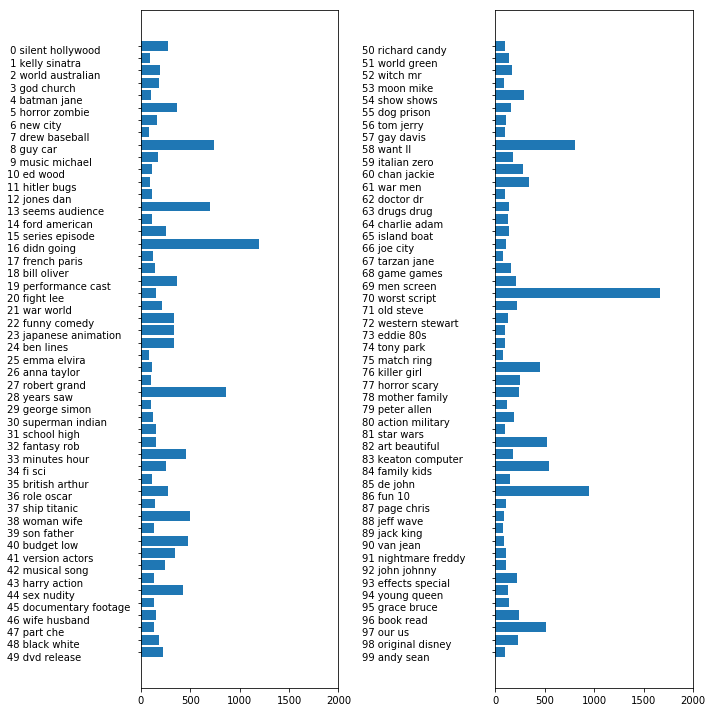

In [25]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1 , 2, figsize=(10,10))
topic_names=["{:>2} ".format(i)+" ".join(words)
            for i , words in enumerate(feature_names[sorting[:,:2]])]

for col in [0,1]:
    start=col*50
    end=(col + 1)*50
    ax[col].barh(np.arange(50),np.sum(document_topics100,axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end],ha='left',va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0,2000)
    yax=ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
    

It seems like LDA mostly discovered two kind of topics, genre-specific and ratingspecific, in addition to several more unspecific topics. This is an interesting discovery, as most reviews are made up of some movie-specific comments and some comments that justify or emphasize the rating.
Topic models like LDA are interesting methods to understand large text corpora in the absence of labels—or, as here, even if labels are available. The LDA algorithm is randomized, though, and changing the random_state parameter can lead to quite different outcomes. While identifying topics can be helpful, any conclusions you draw from an unsupervised model should be taken with a grain of salt, and we recommend verifying your intuition by looking at the documents in a specific topic. The topics produced by the LDA.transform method can also sometimes be used as a compact representation for supervised learning. This is particularly helpful when few training examples are available. 


# Summary and Outlook 

In this chapter we talked about the basics of processing text, also known as natural language processing (NLP), with an example application classifying movie reviews. The tools discussed here should serve as a great starting point when trying to process text data. In particular for text classification tasks such as spam and fraud detection or sentiment analysis, bag-of-words representations provide a simple and powerful solution. As is often the case in machine learning, the representation of the data is key in NLP applications, and inspecting the tokens and n-grams that are extracted can give powerful insights into the modeling process. In text-processing applications, it is often possible to introspect models in a meaningful way, as we saw in this chapter, for both supervised and unsupervised tasks. You should take full advantage of this ability when using NLP-based methods in practice. 

Natural language and text processing is a large research field, and discussing the details of advanced methods is far beyond the scope of this book. If you want to learn more, we recommend the O’Reilly book Natural Language Processing with Python by Steven Bird, Ewan Klein, and Edward Loper, which provides an overview of NLP together with an introduction to the nltk Python package for NLP. Another great and more conceptual book is the standard reference Introduction to Information Retrieval by Christopher Manning, Prabhakar Raghavan, and Hinrich Schütze, which describes fundamental algorithms in information retrieval, NLP, and machine learning. Both books have online versions that can be accessed free of charge. As we discussed earlier, the classes CountVectorizer and TfidfVectorizer only implement relatively simple text-processing methods. For more advanced text-processing methods, we recommend the Python packages spacy (a relatively new but very efficient and welldesigned package), nltk (a very well-established and complete but somewhat dated library), and gensim (an NLP package with an emphasis on topic modeling). 

There have been several very exciting new developments in text processing in recent years, which are outside of the scope of this book and relate to neural networks. The first is the use of continuous vector representations, also known as word vectors or distributed word representations, as implemented in the word2vec library. The original paper “Distributed Representations of Words and Phrases and Their Compositionality” by Thomas Mikolov et al. is a great introduction to the subject. Both spacy and gensim provide functionality for the techniques discussed in this paper and its follow-ups. 

Another direction in NLP that has picked up momentum in recent years is the use of recurrent neural networks (RNNs) for text processing. RNNs are a particularly powerful type of neural network that can produce output that is again text, in contrast to classification models that can only assign class labels. The ability to produce text as output makes RNNs well suited for automatic translation and summarization. An introduction to the topic can be found in the relatively technical paper “Sequence to Sequence Learning with Neural Networks” by Ilya Suskever, Oriol Vinyals, and Quoc Le. A more practical tutorial using the tensorflow framework can be found on the TensorFlow website.
